In [24]:
import os
import json 
import numpy as np

import pandas as pd
pd.options.mode.copy_on_write = True

import xarray as xr
import nc_time_axis

from SALib import ProblemSpec

from src.sobol_sa import wbm_sobol
from utils.global_paths import project_data_path, project_code_path

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['text.usetex'] = False
plt.rcParams["font.size"] = 10
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

obs_colors = {'SMAP':"#e7298a", 'VIC':"#d95f02", 'NOAH':"#7570b3", 'MOSAIC':"#1b9e77"}

### Preliminaries

In [2]:
def store_params(param_dict, N, experiment_name):
    #########################
    # Problem spec for SAlib
    #########################
    param_names = list(param_dict.keys())
    n_params = len(param_names)

    # Check if done
    if not os.path.isfile(f"{project_data_path}/WBM/SA/{experiment_name}_params.txt"):
        sp = ProblemSpec({
            'num_vars': n_params,
            'names': param_names,
            'bounds': [param_dict[param] for param in param_names]
        }).sample_sobol(N)
    
        np.savetxt(f"{project_data_path}/WBM/SA/{experiment_name}_params.txt", sp.samples)
    else:
        print('Parameter file already exists!')

In [3]:
# Plotting function: hist
def make_hist_plot(obs, experiment, save_name):
    # Historical
    df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_{obs}_noCC_res.csv')
    df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_2048_{obs}_noCC_res.csv')
    df_N4096 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_4096_{obs}_noCC_res.csv')

    # Get params
    params = df_N1024['param'].unique()
    n_params = len(params)

    # Get metrics 
    metrics = df_N1024['metric'].unique()

    ######### Plot
    fig, axs = plt.subplots(nrows=int(np.ceil(len(metrics)/3)), ncols=3,
                            figsize=(15,int(np.ceil(len(metrics)/3))*3),
                            sharey=True, sharex=False, gridspec_kw=dict(hspace=0.8))
    axs = axs.flatten()

    # Loop through all
    for ix, metric in enumerate(metrics):
        for id, data in enumerate([df_N1024, df_N2048, df_N4096]):
            axs[ix].bar(x=np.arange(id, (n_params*4) + id, 4),
                        height=data[data.metric == metric]['ST'],
                        yerr=data[data.metric == metric]['ST_conf'],
                        color=f'C{id}')

        # Tidy
        axs[ix].set_xticks(np.arange(1, (n_params*4) + 1, 4), params, rotation=90)
        axs[ix].set_title(metric)
        axs[ix].grid(alpha=0.1)

    # Legend
    custom_lines = [Line2D([0], [0], color='C0', lw=3),
                    Line2D([0], [0], color='C1', lw=3),
                    Line2D([0], [0], color='C2', lw=3)]

    axs[0].legend(custom_lines, ['N=1024', 'N=2048', 'N=4096'])

    # Title
    fig.suptitle(obs, y=0.95, fontweight='bold')

    # Remove unused axes
    unused = int(np.ceil(len(metrics)/3))*3 - len(metrics)
    if unused > 0:
        for ix in range(1,unused+1):
            axs[-ix].axis('off')

    if save_name:
        plt.savefig(f"{project_code_path}/figs/{save_name}.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [4]:
# Plotting function: future
def make_future_plot(obs, metric, experiment):
    # Read CC realizations
    data_all = {}
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                read_name = f"{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                df = pd.read_csv(f"{project_data_path}/WBM/SA/{experiment}_{read_name}_res.csv")
                data_all[read_name] = df

    # Get params
    params = data_all[read_name]['param'].unique()
    n_params = len(params)

    ######### Plot
    fig, axs = plt.subplots(nrows=4, ncols=4,
                            figsize=(15,14),
                            sharey=True, sharex=False, gridspec_kw=dict(hspace=0.75))

    # Loop through all
    for ixt, tas_delta in enumerate([-5, 1, 5, 10]):
        for ixp, prcp_factor in enumerate([0.5, 0.9, 1.1, 1.5]):
            for ixn, N in enumerate([1024, 2048, 4096]):
                # Grab df
                read_name = f"{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                df = data_all[read_name]
                
                # Plot
                axs[ixt, ixp].bar(x=np.arange(ixn, (n_params*4) + ixn, 4),
                                  height=df[df.metric == metric]['ST'],
                                  yerr=df[df.metric == metric]['ST_conf'],
                                  color=f'C{ixn}')

            # Tidy
            axs[ixt, ixp].set_xticks(np.arange(1, (n_params*4) + 1, 4), params, rotation=90)
            axs[ixt, ixp].set_title(f'tas delta: {str(tas_delta)}C, prcp factor: {str(prcp_factor)}')
            axs[ixt, ixp].grid(alpha=0.1)

    # Legend
    custom_lines = [Line2D([0], [0], color='C0', lw=3),
                    Line2D([0], [0], color='C1', lw=3),
                    Line2D([0], [0], color='C2', lw=3)]

    axs[0,0].legend(custom_lines, ['N=1024', 'N=2048', 'N=4096'])

    # Title
    fig.suptitle(f"Perturbed {obs} forcing; {metric}", y=0.92, fontweight='bold')

    plt.show()

In [5]:
def plot_sa_results(experiment, obs_name, metric, all_N, legend, color, title, ax):
    # Names
    param_name_dict = {'Ts':'$T_s$',
                       'Tm':'$T_m$',
                       'wiltingp':'$W_p$',
                       'awCap':'$W_{cap}$',
                       'alpha':r'$\alpha$',
                       'betaHBV':r'$\beta_R$',
                       'GS_start':'$GS_{start}$',
                       'GS_end':'$GS_{end}$',
                       'L_ini':'$L_{ini}$',
                       'L_dev':'$L_{dev}$',
                       'L_mid':'$L_{mid}$',
                       'Kc_ini':'$Kc_{ini}$',
                       'Kc_mid':'$Kc_{mid}$',
                       'Kc_end':'$Kc_{end}$',
                       'Kmin':'$K_{min}$',
                       'Kmax':'$K_{max}$',
                       'c_lai':'$c_{lai}$'}
    
    # Read
    if obs_name == "SMAP":
        df_main = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_4096_{obs_name}_noCC_res.csv')
        if all_N:
            df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_{obs_name}_noCC_res.csv')
            df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_2048_{obs_name}_noCC_res.csv')
    else:
        df_main = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_4096_NLDAS_noCC_res.csv')
        if all_N:
            df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_NLDAS_noCC_res.csv')
            df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_2048_NLDAS_noCC_res.csv')
    
    # Get params
    params = df_main['param'].unique()
    n_params = len(params)

    # Plot
    if all_N:
        colors = ['lightgray', 'darkgray', 'dimgray']
        for id, data in enumerate([df_N1024, df_N2048, df_main]):
            ax.barh(y=np.arange(id, (n_params*4) + id, 4),
                   width=data[data.metric == metric]['ST'],
                   xerr=data[data.metric == metric]['ST_conf'],
                   color=colors[id])

            # Tidy
            ax.set_yticks(np.arange(1, (n_params*4) + 1, 4), [param_name_dict[param] for param in params])

        if legend:
            # Legend
            custom_lines = [Line2D([0], [0], color=colors[2], lw=3),
                            Line2D([0], [0], color=colors[1], lw=3),
                            Line2D([0], [0], color=colors[0], lw=3)]
            ax.legend(custom_lines, ['N=4096', 'N=2048', 'N=1024'])
    else:
        ax.barh(y=np.arange(n_params),
                width=df_main[df_main.metric == metric]['ST'],
                xerr=df_main[df_main.metric == metric]['ST_conf'],
                color=color)
        ax.set_yticks(np.arange(n_params), [param_name_dict[param] for param in params])
        
    # Tidy
    ax.set_title(title)
    ax.grid(alpha=0.1)

# Experiments

## McLean county

### Compute

In [76]:
experiment_name = "mclean"
lat, lon = 40.61752192312278, -88.68366477345201

In [77]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

290
124


In [78]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.4384635315014632
cotton: 0.0
rice: 0.0
sorghum: 9.26961986387762e-05
soybeans: 0.43160019027853863
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.11623816620028393
water: 0.0
evergreen_needleleaf: 0.0
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.0
mixed_forest: 0.0
woodland: 0.006802720949053764
wooded_grassland: 0.006802720949053764
closed_shurbland: 0.0
open_shrubland: 0.0
grassland: 0.0
barren: 0.0
urban: 0.0


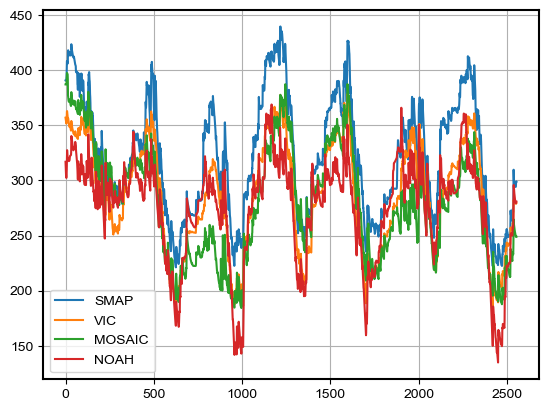

In [79]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [80]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [100, 250] # Wilting point [mm]
param_dict['awCap'] = [200, 400] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize/soy)
param_dict['GS_start'] = [60, 152] 
param_dict['GS_end'] = [244, 334] 
param_dict['L_ini'] = [0.07, 0.22] 
param_dict['L_dev'] = [0.18, 0.33] 
param_dict['L_mid'] = [0.13, 0.38] 
param_dict['Kc_ini'] = [0.1, 0.5] 
param_dict['Kc_mid'] = [1., 1.5] 
param_dict['Kc_end'] = [0.2, 0.6] 
param_dict['Kmin'] = param_dict['Kc_ini']
param_dict['Kmax'] = param_dict['Kc_mid']
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

Parameter file already exists!
Parameter file already exists!
Parameter file already exists!


In [82]:
%%time
# RUN IT
# Historical
for obs_name in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs_name}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs_name, eval=obs_name,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=experiment_name,
                      Kpet_name = "crop",
                      N=N,
                      save_name=save_name)
            print(save_name)

mclean_1024_SMAP_noCC already done
mclean_2048_SMAP_noCC already done
mclean_4096_SMAP_noCC already done
mclean_1024_NLDAS_noCC already done
mclean_2048_NLDAS_noCC already done
mclean_4096_NLDAS_noCC already done
CPU times: user 912 µs, sys: 0 ns, total: 912 µs
Wall time: 10.8 ms


In [ ]:
%%time
# RUN IT
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{experiment_name}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    wbm_sobol(ix=ix, iy=iy,
                           forcing=obs, eval=None,
                           tas_delta=tas_delta, prcp_factor=prcp_factor,
                           experiment_name=experiment_name,
                           Kpet_name="crop",
                           N=N,
                           save_name=save_name)
                    print(save_name)

mclean_1024_SMAP_CCtas-5prcp0.5
mclean_1024_SMAP_CCtas-5prcp0.9
mclean_1024_SMAP_CCtas-5prcp1.1
mclean_1024_SMAP_CCtas-5prcp1.5
mclean_1024_SMAP_CCtas1prcp0.5
mclean_1024_SMAP_CCtas1prcp0.9
mclean_1024_SMAP_CCtas1prcp1.1
mclean_1024_SMAP_CCtas1prcp1.5
mclean_1024_SMAP_CCtas5prcp0.5
mclean_1024_SMAP_CCtas5prcp0.9
mclean_1024_SMAP_CCtas5prcp1.1
mclean_1024_SMAP_CCtas5prcp1.5
mclean_1024_SMAP_CCtas10prcp0.5
mclean_1024_SMAP_CCtas10prcp0.9
mclean_1024_SMAP_CCtas10prcp1.1
mclean_1024_SMAP_CCtas10prcp1.5
mclean_2048_SMAP_CCtas-5prcp0.5
mclean_2048_SMAP_CCtas-5prcp0.9
mclean_2048_SMAP_CCtas-5prcp1.1
mclean_2048_SMAP_CCtas-5prcp1.5
mclean_2048_SMAP_CCtas1prcp0.5
mclean_2048_SMAP_CCtas1prcp0.9
mclean_2048_SMAP_CCtas1prcp1.1
mclean_2048_SMAP_CCtas1prcp1.5
mclean_2048_SMAP_CCtas5prcp0.5
mclean_2048_SMAP_CCtas5prcp0.9
mclean_2048_SMAP_CCtas5prcp1.1
mclean_2048_SMAP_CCtas5prcp1.5
mclean_2048_SMAP_CCtas10prcp0.5
mclean_2048_SMAP_CCtas10prcp0.9
mclean_2048_SMAP_CCtas10prcp1.1
mclean_2048_SMAP_CCtas10

### Plots

In [15]:
# obs_name = "NLDAS"
# experiment = "mclean"
# save_name = f"{experiment}_{obs_name}_hist"

# make_hist_plot(obs_name, experiment, save_name)

In [16]:
# obs_name = "SMAP"
# experiment = "mclean"
# save_name = f"{experiment}_{obs_name}_hist"

# make_hist_plot(obs_name, experiment, save_name)

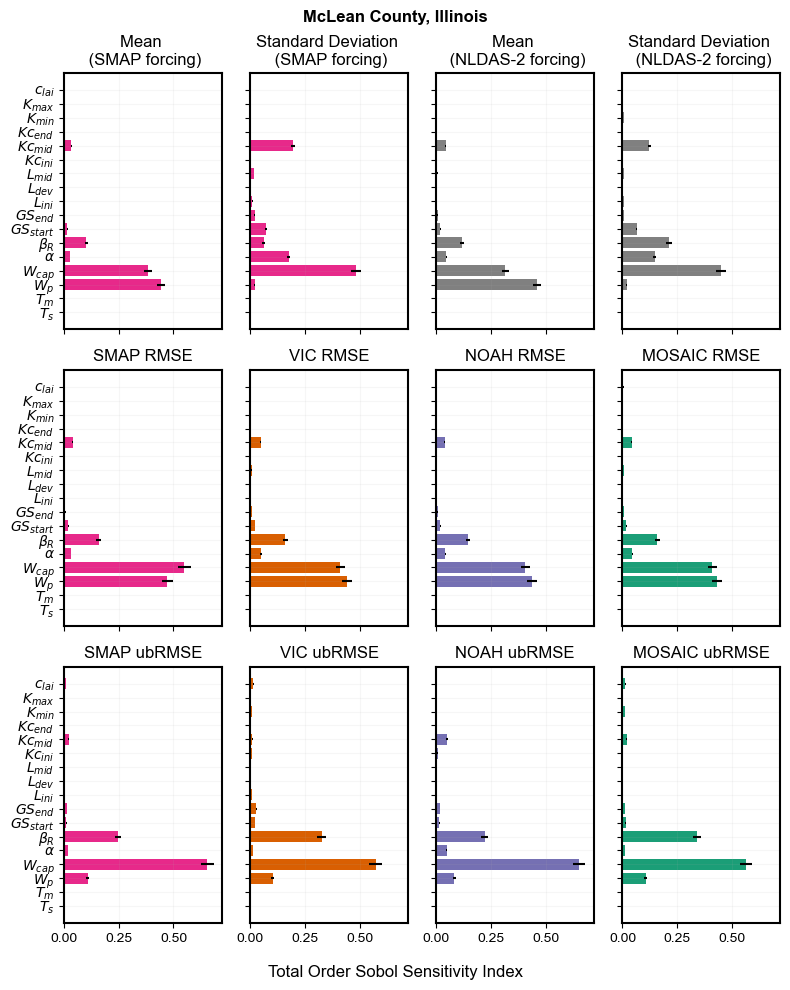

In [62]:
# Historical
experiment = "mclean"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", False, False, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", False, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", False, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", False, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('McLean County, Illinois', fontweight='bold')

plt.tight_layout()

plt.show()

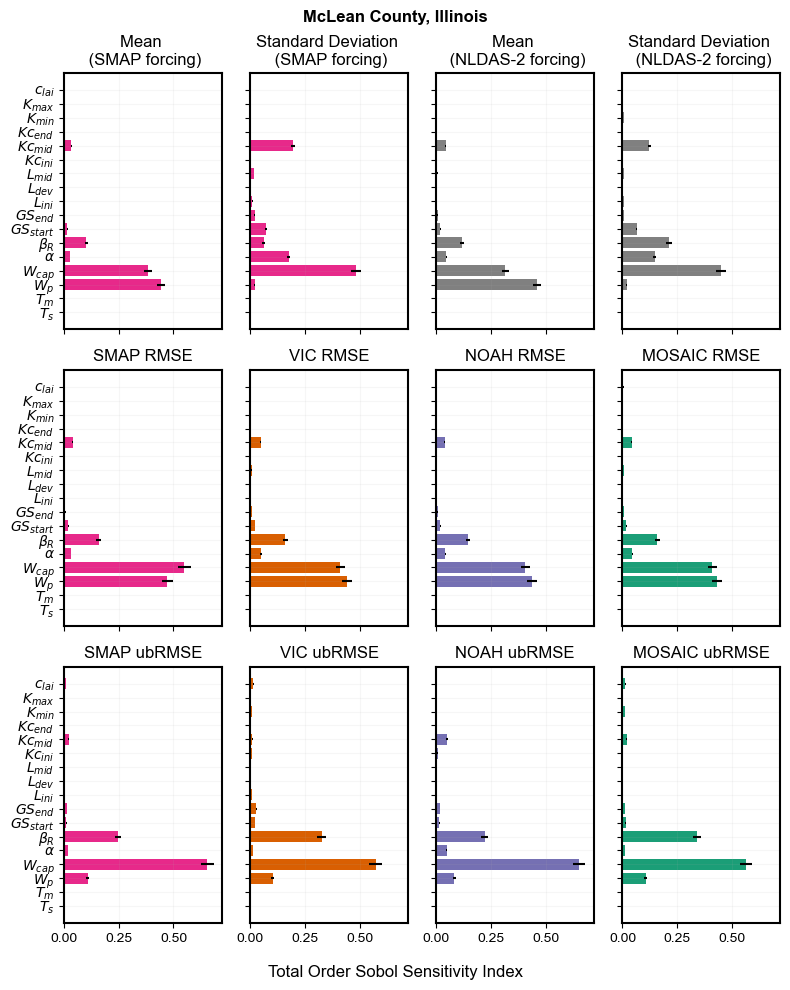

In [63]:
# Historical
experiment = "mclean"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", False, False, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", False, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", False, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", False, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('McLean County, Illinois', fontweight='bold')

plt.tight_layout()

plt.show()

## Smoky Mountains

In [23]:
experiment_name = "smoky"
lat, lon = 35.61832908163286, -83.66546369858804

In [24]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

330
84


In [25]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.0
cotton: 0.0
rice: 0.0
sorghum: 0.0
soybeans: 0.0
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.0
water: 0.0
evergreen_needleleaf: 0.012658228166401386
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.9303797483444214
mixed_forest: 0.0569620244204998
woodland: 0.0
wooded_grassland: 0.0
closed_shurbland: 0.0
open_shrubland: 0.0
grassland: 0.0
barren: 0.0
urban: 0.0


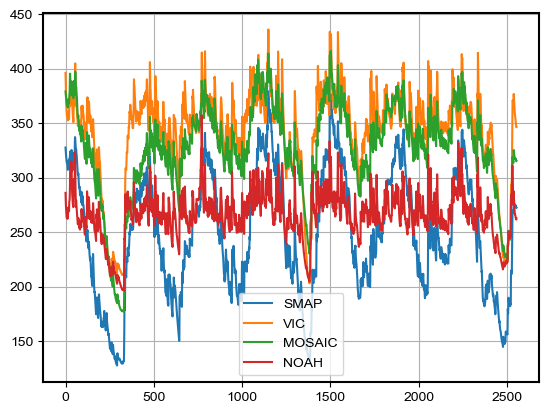

In [26]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [28]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [100, 250] # Wilting point [mm]
param_dict['awCap'] = [150, 300] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize)
param_dict['Kmin'] = [0.1, 2]
param_dict['Kmax'] = [0.1, 2]
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

In [29]:
%%time
# Historical
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs, eval=obs,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=experiment_name,
                      Kpet_name="gen",
                      N=N,
                      save_name=save_name)
            print(save_name)

smoky_1024_SMAP_noCC
smoky_2048_SMAP_noCC
smoky_4096_SMAP_noCC
smoky_1024_NLDAS_noCC
smoky_2048_NLDAS_noCC
smoky_4096_NLDAS_noCC
CPU times: user 6min 42s, sys: 31.8 s, total: 7min 14s
Wall time: 8min 43s


In [ ]:
%%time
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{experiment_name}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    wbm_sobol(ix=ix, iy=iy,
                           forcing=obs, eval=None,
                           tas_delta=tas_delta, prcp_factor=prcp_factor,
                           experiment_name=experiment_name,
                           Kpet_name="gen",
                           N=N,
                           save_name=save_name)
                    print(save_name)

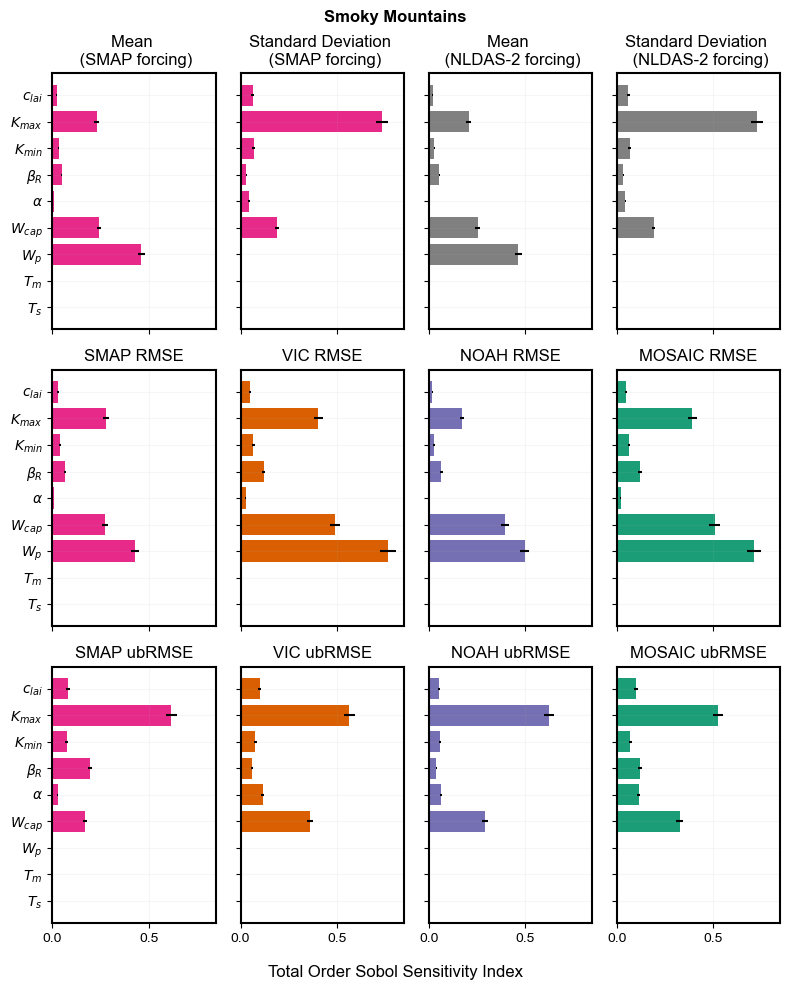

In [30]:
# Historical
experiment = "smoky"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", False, False, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", False, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", False, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", False, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('Smoky Mountains', fontweight='bold')

plt.tight_layout()

plt.show()

## Big Bend

### Compute

In [10]:
experiment_name = "bigbend"
lat, lon = 29.22124625856724, -103.22586554830667

In [11]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

174
33


In [12]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.0
cotton: 0.0
rice: 0.0
sorghum: 0.0
soybeans: 0.0
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.0
water: 0.0
evergreen_needleleaf: 0.0
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.0
mixed_forest: 0.0
woodland: 0.0
wooded_grassland: 0.0
closed_shurbland: 0.23699422180652618
open_shrubland: 0.6531791687011719
grassland: 0.10982658714056015
barren: 0.0
urban: 0.0


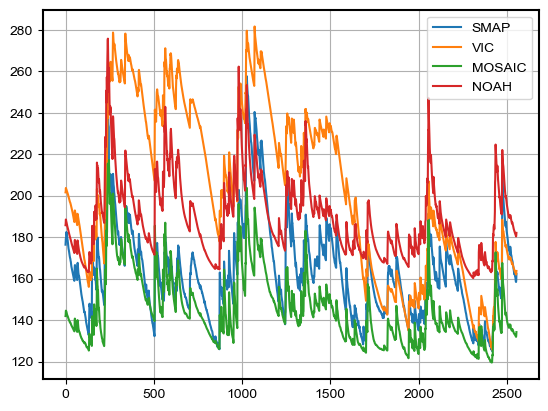

In [13]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [14]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [120, 180] # Wilting point [mm]
param_dict['awCap'] = [100, 150] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize)
param_dict['Kmin'] = [0.1, 2]
param_dict['Kmax'] = [0.1, 2]
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

In [15]:
%%time
# Historical
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs, eval=obs,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=experiment_name,
                      Kpet_name="gen",
                      N=N,
                      save_name=save_name)
            print(save_name)

bigbend_1024_SMAP_noCC
bigbend_2048_SMAP_noCC
bigbend_4096_SMAP_noCC
bigbend_1024_NLDAS_noCC
bigbend_2048_NLDAS_noCC
bigbend_4096_NLDAS_noCC
CPU times: user 6min 44s, sys: 29.6 s, total: 7min 14s
Wall time: 8min 47s


In [ ]:
%%time
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{experiment_name}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    wbm_sobol(ix=ix, iy=iy,
                           forcing=obs, eval=None,
                           tas_delta=tas_delta, prcp_factor=prcp_factor,
                           experiment_name=experiment_name,
                           Kpet_name="gen",
                           N=N,
                           save_name=save_name)
                    print(save_name)

### Plots

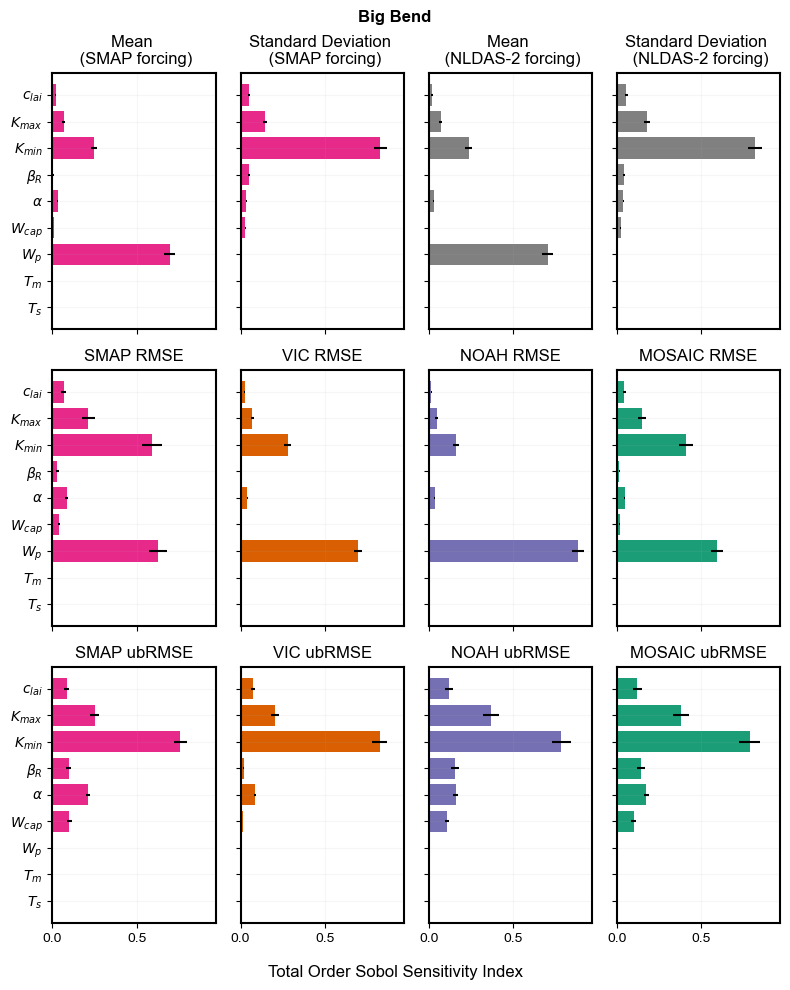

In [20]:
# Historical
experiment = "bigbend"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", False, False, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", False, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", False, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", False, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('Big Bend', fontweight='bold')

plt.tight_layout()

plt.show()

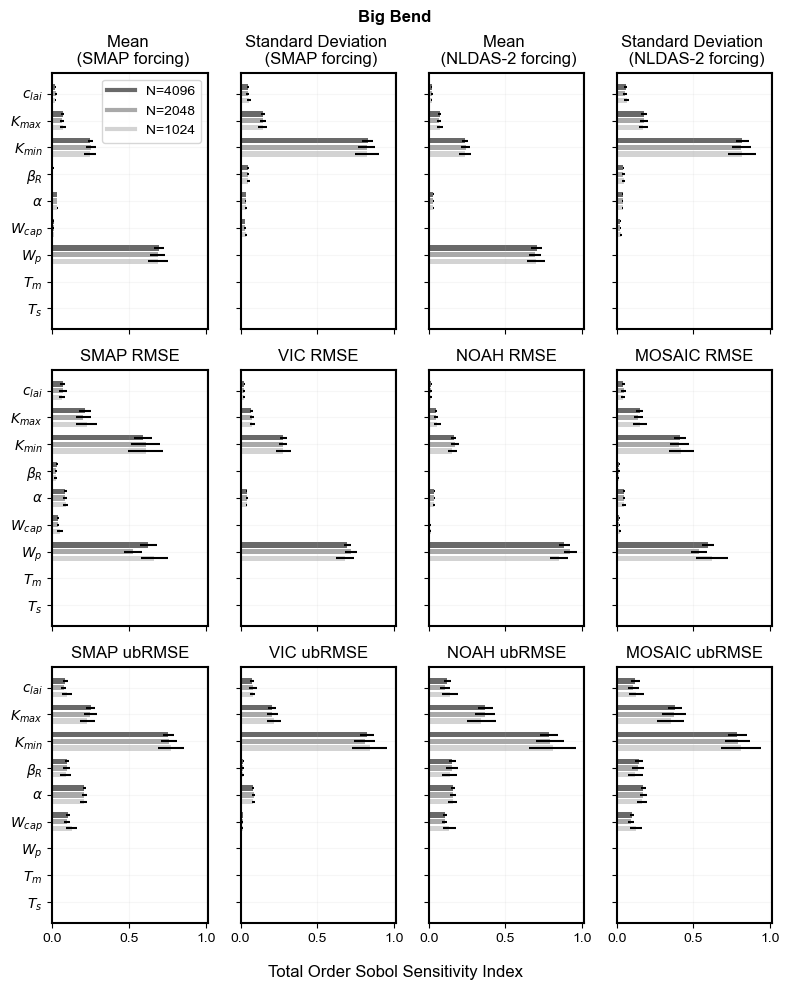

In [21]:
# Historical
experiment = "bigbend"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", True, True, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", True, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", True, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", True, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", True, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", True, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('Big Bend', fontweight='bold')

plt.tight_layout()

plt.show()

## Plot: main

In [28]:
def plot_timeseries(coords, ax, legend):
    lat, lon = coords
    # Get location coordinates
    ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
    lons = ds_grid.lon
    lats = ds_grid.lat

    # Get indices
    ix = (np.abs(lons - lon)).argmin().values
    iy = (np.abs(lats - lat)).argmin().values

    # x-axis
    time = xr.cftime_range(start='2016-01-01', end='2022-12-31', calendar='365_day')

    # Plot
    for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
        ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
        ax.plot(time, ds_tmp[ix, iy, :], label=obs_name, color=obs_colors[obs_name])
    
    # Tidy
    ax.grid()
    ax.set_ylabel('Soil Moisture [mm]')
    if legend:
        ax.legend()

In [47]:
def make_sobol_plot(experiment, ax):
    obs_names = ['SMAP', 'NLDAS']
    
    # Read all
    df = []
    for obs in obs_names:
        df_tmp = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_4096_{obs}_noCC_res.csv')
        df_tmp = df_tmp.replace('mean', f'mean_{obs}')
        df_tmp = df_tmp.replace('sd', f'sd_{obs}')
        df_tmp = df_tmp.replace('range', f'range_{obs}')
        df.append(df_tmp)

    df = pd.concat(df)

    # Get params
    params = df['param'].unique()

    # Select and normalize
    df_plot = df[df['metric'].isin(metrics_to_include)]
    df_plot["ST_norm"] = df_plot["ST"] / df_plot.groupby("metric")["ST"].transform("sum")
    df_plot = df_plot.pivot(index='metric', columns='param', values='ST_norm')[params]
    df_plot = df_plot.reindex(metrics_to_include[::-1])

    # Plot
    df_plot.plot.barh(stacked=True, legend=False, ax=ax)
    
    ax.set_yticklabels(ylabels[::-1])
    ax.set_ylabel('')
    ax.set_xlabel('Total Order Sobol Index (normalized)')
    ax.set_xlim([0,1])

In [48]:
# Info
experiments = ['bigbend', 'smoky', 'mclean']
coords = {'mclean': (40.61752192312278, -88.68366477345201), 
          'bigbend': (29.22124625856724, -103.22586554830667),
          'smoky': (35.61832908163286, -83.66546369858804)}

metrics_to_include = ['mean_SMAP', 'sd_SMAP', 
                      'mean_NLDAS', 'sd_NLDAS', 
                      'rmse_SMAP', 'rmse_VIC', 'rmse_NOAH', 'rmse_MOSAIC',
                      'ubrmse_SMAP', 'ubrmse_VIC', 'ubrmse_NOAH', 'ubrmse_MOSAIC']

ylabels = ['Mean (SMAP forcing)', 'Std. Dev. (SMAP forcing)',
          'Mean (NLDAS forcing)', 'Std. Dev. (NLDAS forcing)',
          'SMAP RMSE', 'VIC RMSE', 'NOAH RMSE', 'MOSAIC RMSE',
          'SMAP ubRMSE', 'VIC ubRMSE', 'NOAH ubRMSE', 'MOSAIC ubRMSE']

param_colors_gen = []
param_colors_crop = []

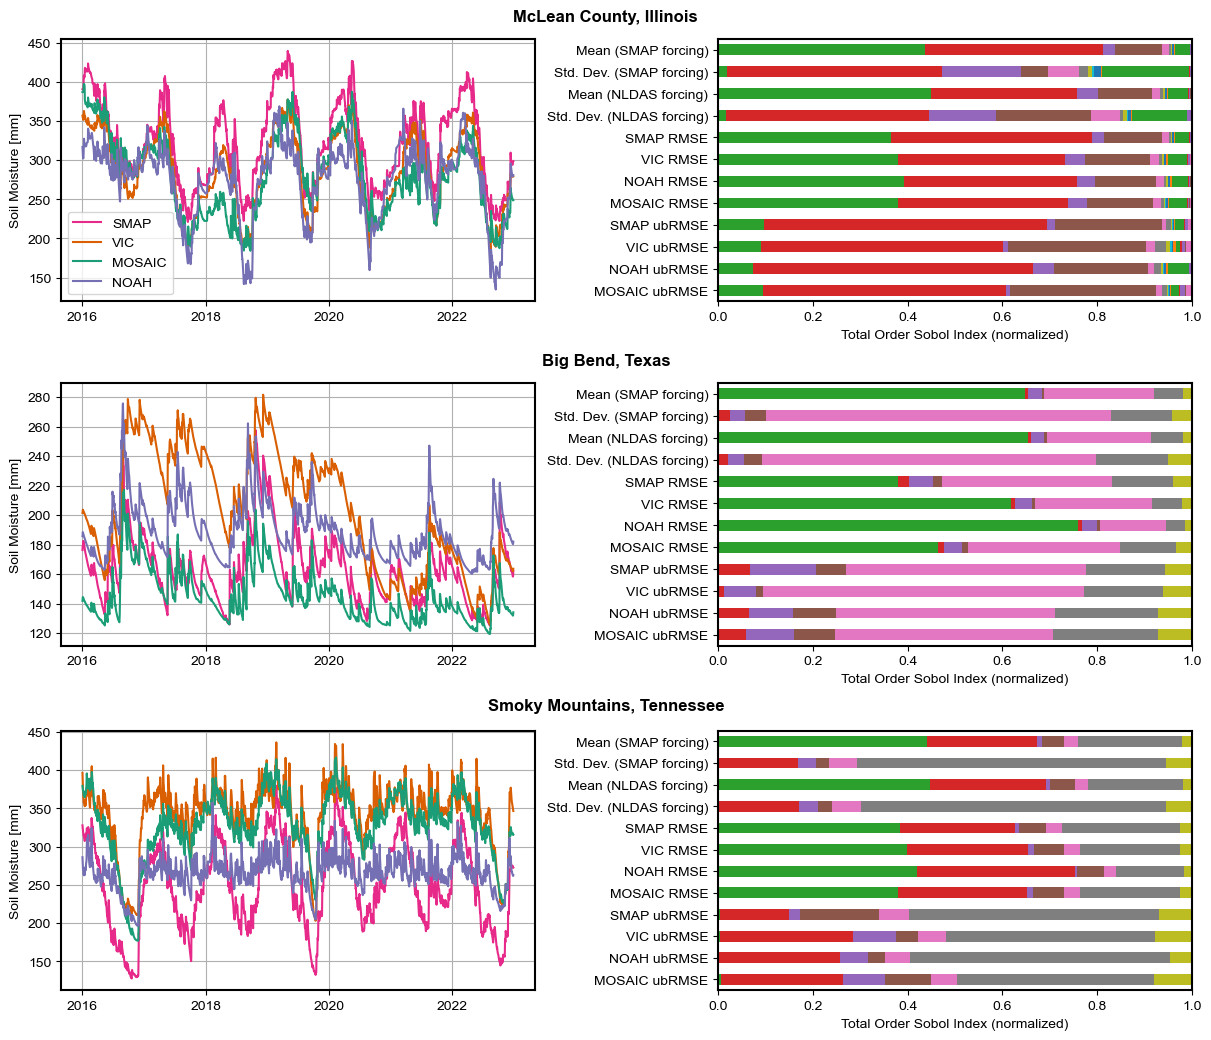

In [49]:
fig = plt.figure(layout='constrained', figsize=(12,10))
subfigs = fig.subfigures(3, 1, hspace=0.1)

# McLean
subfigs[0].suptitle('McLean County, Illinois', fontweight='bold', y=1.08)
axs = subfigs[0].subplots(1, 2)
experiment = "mclean"
plot_timeseries(coords[experiment], axs[0], True)
make_sobol_plot(experiment, axs[1])

# Big Bend
subfigs[1].suptitle('Big Bend, Texas', fontweight='bold', y=1.08)
axs = subfigs[1].subplots(1, 2)
experiment = "bigbend"
plot_timeseries(coords[experiment], axs[0], False)
make_sobol_plot(experiment, axs[1])

# Smoky
axs = subfigs[2].subplots(1, 2)
subfigs[2].suptitle('Smoky Mountains, Tennessee', fontweight='bold', y=1.08)
experiment = "smoky"
plot_timeseries(coords[experiment], axs[0], False)
make_sobol_plot(experiment, axs[1])

plt.show()